In [6]:
import numpy as np
from numpy.linalg import eigh, svd, norm
from scipy.linalg import orth
from sklearn.metrics.pairwise import rbf_kernel, pairwise_distances
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# ========================== #
#     参数设置与样本生成      #
# ========================== #
np.random.seed(0)
d = 1000       # 特征维度
p = 2          # 子空间维度
alpha = 6      # 采样比 α
n = int(alpha * d)

# 真子空间 W_star（正交基）
W_star = np.random.randn(d, p)
W_star, _ = np.linalg.qr(W_star)

# 输入样本 X ∈ ℝ^{n×d}
X = np.random.randn(n, d) / np.sqrt(d)

# 隐变量 Z = X @ W_star
Z = X @ W_star
Z_centered = Z - Z.mean(axis=0, keepdims=True)

# ========================== #
#      原始 link function     #
# ========================== #
def link_function(z):
    return np.sum(z**2, axis=1) / p

y = link_function(Z).reshape(-1, 1)

# ========================== #
#     σ 网格搜索优化          #
# ========================== #
pairwise_dists = pairwise_distances(y)
median_sigma = np.median(pairwise_dists)
sigma_list = np.logspace(np.log10(median_sigma * 0.2), np.log10(median_sigma * 5), 10)

best_score = 0
best_results = {}

for sigma in sigma_list:
    y_std = (y - y.mean()) / y.std()
    gamma = 1.0 / (2 * sigma ** 2)
    K = rbf_kernel(y_std, y_std, gamma=gamma)
    K /= K.sum(axis=1, keepdims=True)

    E_matrices = np.zeros((n, p, p))
    zzts = np.einsum('ij,ik->ijk', Z_centered, Z_centered)
    for i in range(n):
        E_matrices[i] = np.tensordot(K[i], zzts, axes=1)

    # 减去全局均值（用户指定保留）
    E_global = np.mean(E_matrices, axis=0)
    E_matrices -= E_global[np.newaxis, :, :]

    # 加强正则
    E_matrices += 1e-3 * np.eye(p)[np.newaxis, :, :]

    # ========================== #
    #     构造对称谱矩阵          #
    # ========================== #
    T_matrix = np.zeros((d * p, d * p))
    for i in range(n):
        x = X[i]
        T_y = E_matrices[i]
        for a in range(p):
            for b in range(p):
                T_matrix[a*d:(a+1)*d, b*d:(b+1)*d] += T_y[a, b] * np.outer(x, x)
    T_matrix /= (n * d)

    # ========================== #
    #     谱分解与子空间提取       #
    # ========================== #
    eigvals, eigvecs = eigh(T_matrix)
    top_components = eigvecs[:, -p:]

    # 拼接 block 后 QR（更稳健）
    W_blocks = [top_components[i*d:(i+1)*d] for i in range(p)]
    W_avg = np.mean(W_blocks, axis=0)   # shape: (d, p)
    W_hat = orth(W_avg)                 # 正交化，shape: (d, p)

    # 计算 Weak Recovery
    Q = W_star @ W_star.T
    P_hat = W_hat @ W_hat.T
    M_hat = P_hat @ Q @ P_hat
    weak_score = norm(M_hat, ord='fro')**2 / np.trace(Q)

    # 计算 Alignment
    U_align, _, Vt_align = svd(W_star.T @ W_hat)
    align_score = np.mean(np.diag(U_align @ Vt_align) ** 2)

    # 记录最优
    if weak_score > best_score:
        best_score = weak_score
        best_results = {
            'eigvals': eigvals,
            'W_hat': W_hat,
            'align_score': align_score,
            'sigma': sigma,
            'weak_score': weak_score
        }



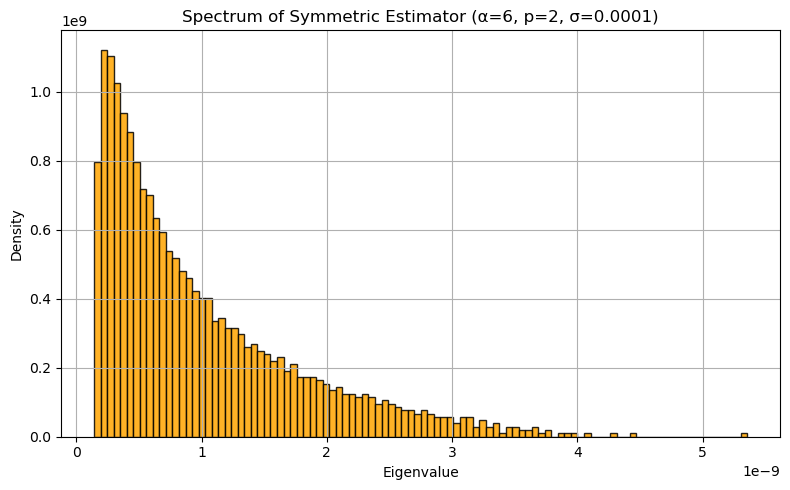

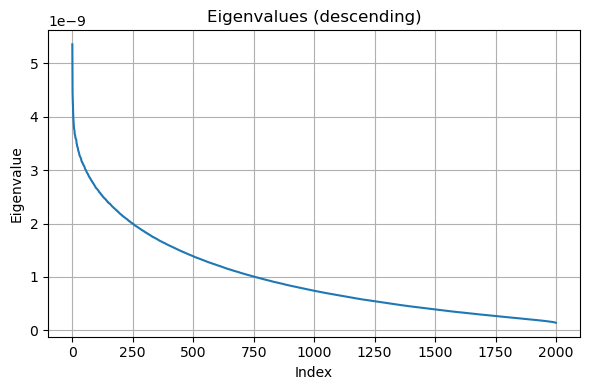

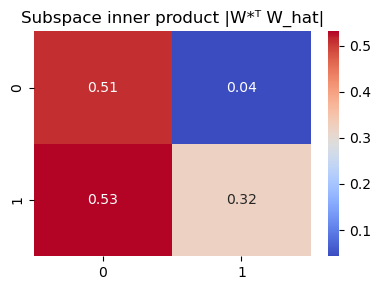

Top-2 eigenvalue energy ratio: 0.0049
✅ Best σ: 0.0001
✅ Subspace alignment score: 0.7448
✅ Weak recovery score:      0.1913


In [7]:
# ========================== #
#     可视化与输出             #
# ========================== #
eigvals = best_results['eigvals']
W_hat = best_results['W_hat']
alignment_score = best_results['align_score']
weak_recovery_score = best_results['weak_score']
sigma_opt = best_results['sigma']

plt.figure(figsize=(8, 5))
plt.hist(eigvals, bins=100, density=True, color='orange', edgecolor='black', alpha=0.85)
plt.title(f"Spectrum of Symmetric Estimator (α={alpha}, p={p}, σ={sigma_opt:.4f})")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(eigvals[::-1])
plt.title("Eigenvalues (descending)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()
plt.show()

# 子空间方向热力图
plt.figure(figsize=(4, 3))
sns.heatmap(np.abs(W_star.T @ W_hat), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Subspace inner product |W*ᵀ W_hat|")
plt.tight_layout()
plt.show()

# 特征值能量占比输出
top_energy = np.sum(eigvals[-p:])
total_energy = np.sum(eigvals)
print(f"Top-{p} eigenvalue energy ratio: {top_energy / total_energy:.4f}")
print(f"✅ Best σ: {sigma_opt:.4f}")
print(f"✅ Subspace alignment score: {alignment_score:.4f}")
print(f"✅ Weak recovery score:      {weak_recovery_score:.4f}")

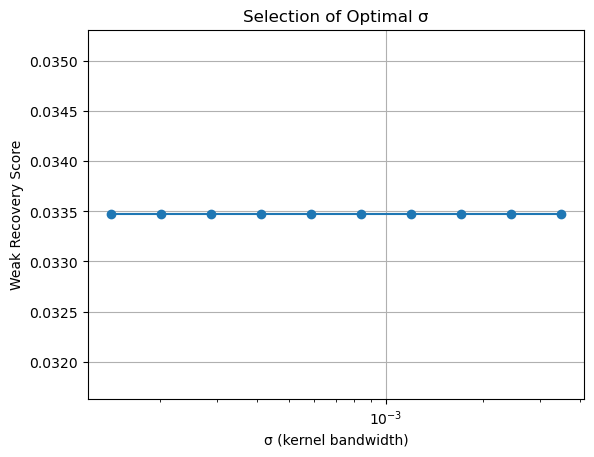

In [8]:
weak_scores = []
for sigma in sigma_list:
    ...
    weak_scores.append(weak_score)

plt.semilogx(sigma_list, weak_scores, marker='o')
plt.xlabel("σ (kernel bandwidth)")
plt.ylabel("Weak Recovery Score")
plt.title("Selection of Optimal σ")
plt.grid(True)
plt.show()


Constructing symmetric estimator: 100%|██████████| 6000/6000 [01:24<00:00, 70.78it/s]


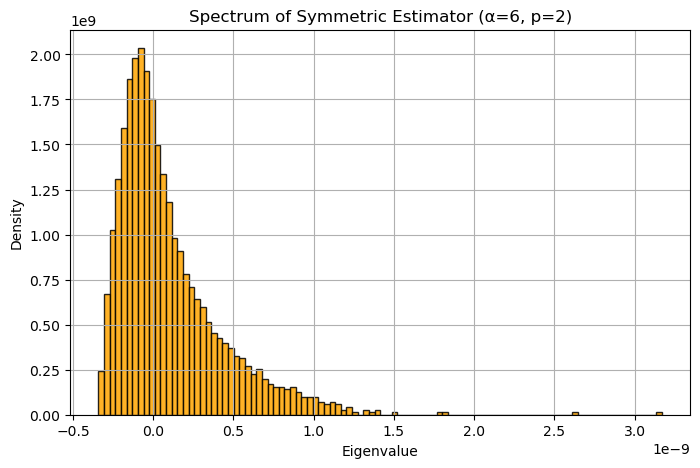

Top-2 eigenvalue energy ratio: 0.0288


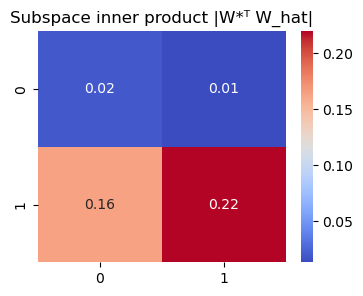

✅ Subspace alignment score: 0.6464
✅ Weak recovery score:      0.0028


In [5]:
import numpy as np
from numpy.linalg import eigh, svd, norm
from scipy.linalg import orth
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# ========================== #
#     参数设置与样本生成      #
# ========================== #
d = 1000       # 特征维度
p = 2          # 子空间维度
alpha = 6      # 采样比 α
n = int(alpha * d)



np.random.seed(0)

# 真子空间 W_star（正交基）
W_star = np.random.randn(d, p)
W_star, _ = np.linalg.qr(W_star)

# 输入样本 X ∈ ℝ^{n×d}
X = np.random.randn(n, d) / np.sqrt(d)

# 隐变量 Z = X @ W_star
Z = X @ W_star

# Zero-mean 化 Z（关键步骤）
Z_centered = Z - Z.mean(axis=0, keepdims=True)

# link function: g(z) = ||z||² / p
def link_function(z):
    return np.sum(z**2, axis=1) / p

y = link_function(Z).reshape(-1, 1)

# ========================== #
#     σ计算：基于 y 的距离中位数 #
# ========================== #

from sklearn.metrics import pairwise_distances
pairwise_dists = pairwise_distances(y)
sigma = np.median(pairwise_dists)


# ========================== #
#     核估计条件期望 E[zzᵀ|y] #
# ========================== #
gamma = 1.0 / (2 * sigma ** 2)
K = rbf_kernel(y, y, gamma=gamma)
K /= K.sum(axis=1, keepdims=True)

E_matrices = np.zeros((n, p, p))
zzts = np.einsum('ij,ik->ijk', Z_centered, Z_centered)  # 预先构造所有 z_j z_jᵀ
for i in range(n):
    weighted_sum = np.tensordot(K[i], zzts, axes=1)
    E_matrices[i] = weighted_sum

# 减去整体均值，确保构造 unbiased（optional but helpful）
E_global = np.mean(E_matrices, axis=0)
E_matrices -= E_global[np.newaxis, :, :]

# 正则化防止奇异
E_matrices += 1e-4 * np.eye(p)[np.newaxis, :, :]

# ========================== #
#     构造对称谱矩阵          #
# ========================== #
T_matrix = np.zeros((d * p, d * p))
for i in tqdm(range(n), desc="Constructing symmetric estimator"):
    x = X[i]
    T_y = E_matrices[i]
    for a in range(p):
        for b in range(p):
            T_matrix[a*d:(a+1)*d, b*d:(b+1)*d] += T_y[a, b] * np.outer(x, x)
T_matrix /= (n * d)

# ========================== #
#     谱分解与子空间提取       #
# ========================== #
eigvals, eigvecs = eigh(T_matrix)
top_components = eigvecs[:, -p:]  # 最后 p 个特征向量

# 更稳健的子空间拼接方式（避免秩退化）
W_blocks = [top_components[i*d:(i+1)*d] for i in range(p)]
W_hat_raw = np.mean(W_blocks, axis=0)
W_hat = orth(W_hat_raw)

# ========================== #
#     计算 Weak Recovery 分数  #
# ========================== #
Q = W_star @ W_star.T            # 真子空间投影矩阵
P_hat = W_hat @ W_hat.T          # 估计子空间投影矩阵
M_hat = P_hat @ Q @ P_hat
weak_recovery_score = norm(M_hat, ord='fro')**2 / np.trace(Q)

# ========================== #
#     子空间对齐度计算         #
# ========================== #
U_align, _, Vt_align = svd(W_star.T @ W_hat)
alignment_score = np.mean(np.diag(U_align @ Vt_align) ** 2)

# ========================== #
#     可视化与输出             #
# ========================== #
plt.figure(figsize=(8, 5))
plt.hist(eigvals, bins=100, density=True, color='orange', edgecolor='black', alpha=0.85)
plt.title(f"Spectrum of Symmetric Estimator (α={alpha}, p={p})")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# 特征值能量占比输出
total_energy = np.sum(eigvals)
top_energy = np.sum(eigvals[-p:])
print(f"Top-{p} eigenvalue energy ratio: {top_energy / total_energy:.4f}")

# 子空间方向热力图
plt.figure(figsize=(4, 3))
sns.heatmap(np.abs(W_star.T @ W_hat), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Subspace inner product |W*ᵀ W_hat|")
plt.show()

# 最终打印结果
print(f"✅ Subspace alignment score: {alignment_score:.4f}")
print(f"✅ Weak recovery score:      {weak_recovery_score:.4f}")
